In [2]:
import numpy as np
import matplotlib.pyplot as plt
from worm_env import *

In [54]:
traj = np.load('Data/Qtab_i0_12.npz',allow_pickle=True)

In [57]:
traj_tot = {}
for i in range(16):
    traj = np.load('Data/Qtab_i0_'+str(i)+'.npz',allow_pickle=True)
    add_to_traj(traj_tot,traj)

#np.savez('Data/Qtab_i0.npz',**traj_tot,allow_pickle=True)

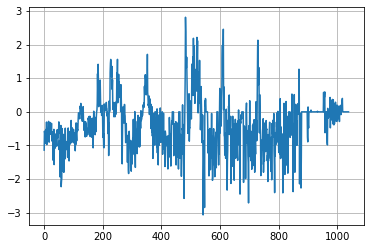

In [55]:
plt.plot(traj['reward'])
plt.grid();

In [56]:
np.sum(traj['reward'])/300

-1.3078849429003745

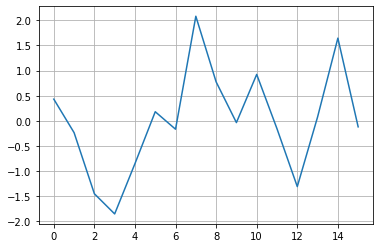

In [58]:
av_rew = [np.sum(traj_tot['reward'][i])/300 for i in range(16)]
plt.plot(av_rew)
plt.grid();

In [63]:
traj = traj_tot['loc'][13]

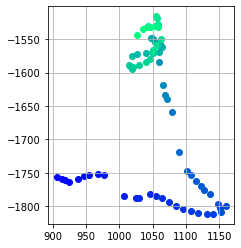

In [64]:
fig,ax = plt.subplots(1)
#fig.set_size_inches((12,12))
NPOINTS = traj[::10,:].shape[0]
track = traj[::10,:]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,0],-track[i,1])
    ax.set_aspect('equal','box')
ax.grid();